# Imports

In [1]:
import numpy as np
import mdtraj as md
import matplotlib as mpl
import matplotlib.pyplot as plt
import nglview as ngl

from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as u
import openmmtools.integrators as toolIntegrators

from custom_gromacstopfile import CustomGromacsTopFile

import os
import sys
import glob

_ColormakerRegistry()

In [2]:
%matplotlib inline
# widget for jupyterlab, notebook for jupyter-notebooks, inline for debugging
%load_ext autoreload
%autoreload 2

# Understand Gromacs .itp files

Let's load an example forcefield.itp file. This forcefield file is also included in the .top file every gromacs simulation needs.

The #include statements link to other files. These #includes can be traced back all the way to the LJ parameters, the spring constants, etc. The files can either be in the same dir as forcefield.itp or in the gromacs/top folder. The top folder is defined via the environment variable GMXDATA

In [3]:
gmxdata = os.environ['GMXDATA']
top = os.path.join(gmxdata, 'top')
files = glob.glob(top+'/*')
for file in files:
    if 'gromos' in file: print(file) 

KeyError: 'GMXDATA'

## Bonded interactions

the #define gb_1 is special to GROMOS96 type ffs, which pass a string to the C preprocessor. The interactions are numberd with gd_x. This line defines the parameters for interaction gb_1 (bonded). In this case an equilibrium bond length of 0.1 $nm$ and a spring constant of 1.5700e+07 $kJ \cdot mol^{-1} \cdot nm^{-4}$. The ; H - O 750 is just a comment to see what bond is defined here. I don't know what the 750 stands for.

In the topol.top of the simulation we will find the gb_2 again in the [ bonds ] section. Here we define a bond between atom 1 (ai = 1) and atom 2 (aj = 2) with a functional of 2 (more on functials later) and use the parameters gb_2

In [6]:
with open("/home/kair/hiwi/KR0018/example_sim_kevin/topol.top", 'r') as f:
    lines = f.read().splitlines()
for i, line in enumerate(lines):
    if '[ atoms ]' in line: print('\n'.join(lines[i:i+20]))
    if '[ bonds ]' in line: print('\n'.join(lines[i:i+20]))

[ atoms ]
;   nr       type  resnr residue  atom   cgnr     charge       mass  typeB    chargeB      massB
; residue   1 MET rtp MET  q +1.0
     1         NL      1    MET      N      1      0.129    14.0067   ; qtot 0.129
     2          H      1    MET     H1      1      0.248      1.008   ; qtot 0.377
     3          H      1    MET     H2      1      0.248      1.008   ; qtot 0.625
     4          H      1    MET     H3      1      0.248      1.008   ; qtot 0.873
     5        CH1      1    MET     CA      2      0.127     13.019   ; qtot 1
     6        CH2      1    MET     CB      2          0     14.027   ; qtot 1
     7        CH2      1    MET     CG      3      0.241     14.027   ; qtot 1.241
     8          S      1    MET     SD      3     -0.482      32.06   ; qtot 0.759
     9        CH3      1    MET     CE      3      0.241     15.035   ; qtot 1
    10          C      1    MET      C      4       0.45     12.011   ; qtot 1.45
    11          O      1    MET      O    

Sources: http://manual.gromacs.org/documentation/2019/reference-manual/functions/bonded-interactions.html

http://manual.gromacs.org/documentation/current/reference-manual/topologies/topology-file-formats.html

There are also angles (ga_x) dihedrals (gd_x) and improper dihedrals (gi_x). Every bonded interaction comes with its own functional. The functional gives the function these interactions follow. Bonded functional 2 is a power of 4 functional following these equations: 

$ V_b (r_{ij}) = \frac{1}{4} \cdot k^b_{ij} \left( r^2_{ij} - b^2_{ij}\right)^2$

The corresponding force is:

$ \mathbf{F_i} (\mathbf{r_{ij}}) = k^b_{ij} \cdot \left( r^2_{ij} - b^2_{ij}\right) \cdot \mathbf{r_{ij}}$

By comparing the terms for a harmonic bond potential, the definitions are as follows:
* $k$: The force constant of the bond
* $r$: The distance between i and j
* $b$: The equilibrium distance between i and j
* $\mathbf{r}$: The vector between i and j

The list goes on and on.

In [7]:
with open("/home/kair/hiwi/KR0018/example_sim_kevin/topol.top", 'r') as f:
    lines = f.read().splitlines()
for i, line in enumerate(lines):
    if '[ dihedrals ]' in line: print('\n'.join(lines[i:i+20]))
    if '[ angles ]' in line: print('\n'.join(lines[i:i+20]))

[ angles ]
;  ai    aj    ak funct            c0            c1            c2            c3
    2     1     3     2    ga_10
    2     1     4     2    ga_10
    2     1     5     2    ga_11
    3     1     4     2    ga_10
    3     1     5     2    ga_11
    4     1     5     2    ga_11
    1     5     6     2    ga_13
    1     5    10     2    ga_13
    6     5    10     2    ga_13
    5     6     7     2    ga_15
    6     7     8     2    ga_16
    7     8     9     2    ga_4
    5    10    11     2    ga_30
    5    10    12     2    ga_19
   11    10    12     2    ga_33
   10    12    13     2    ga_32
   10    12    14     2    ga_31
   13    12    14     2    ga_18
[ dihedrals ]
;  ai    aj    ak    al funct            c0            c1            c2            c3            c4            c5
    2     1     5    10     1    gd_29
    1     5     6     7     1    gd_34
    1     5    10    12     1    gd_45
    1     5    10    12     1    gd_42
    5     6     7     8     1   

## Nonbonded interactions

Similar stuff happens for non-bonded interactions. Here two things can happen:

1) The LJ parameters of the interaction between two atoms are known. Good ->Plug them into the equation.

2) The parameters are not knwon. Use per-atom LJ parameters and combine them via one of the following combination rules.

* **1** V = C(6), W = C(12), both geometric average
* **2** V = $\sigma$, W = $\epsilon$, sigma arithmetic and epsilon geometric average
* **3** V = $\sigma$, W = $\epsilon$, both geometric average

Here's what I have already done:

I changed the Gromacstopfile class so it understands all Gromos parameters. However, the forces are not implemented yet.

# Use OpenMM gromacs topfile parser on a topol.top with gromos

In [8]:
basedir = "/home/kair/hiwi/KR0018/example_sim_kevin"
topfile = os.path.join(basedir, 'topol.top')

In [9]:
from gromacstopfile_ver_3_6 import GromacsTopFile

The dir /home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/ is where the isopeptide version of gromos54a7 is stored.

In [10]:
system = GromacsTopFile(topfile, includeDir="/home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/")

('/home/kair/hiwi/KR0018/example_sim_kevin', '/home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/', '/home/kair/hiwi/KR0018/example_sim_kevin')
('/home/kair/hiwi/KR0018/example_sim_kevin', '/home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/', '/home/kair/hiwi/KR0018/example_sim_kevin/./gromos54a7.ff')
('/home/kair/hiwi/KR0018/example_sim_kevin', '/home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/', '/home/kair/hiwi/KR0018/example_sim_kevin/./gromos54a7.ff')
('/home/kair/hiwi/KR0018/example_sim_kevin', '/home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/', '/home/kair/hiwi/KR0018/example_sim_kevin/./gromos54a7.ff')


ValueError: Unsupported function type in [ bonds ] line:      1     2     2    0.1000  1.8700e+07


## Error 1: ValueError: Unsupported function type in [ bondtypes ] line:  S      S       2    0.2040  5.0300e+06

To understand this error we need to take a quick look at how gromacs forcefield files work.

The main file is /home/soft/gromacs/gromacs-2019.1/inst/cuda_shared_AVX_512/share/gromacs/top/gromos54a7_isop.ff/forcefield.itp

When you track the #include somefile.itp in these files, you can trace everything back until you reach the LJ parameters, spring constants, etc. Let's follow the trace. The error says it doesn't know the bondtype (2) between two sulfur atoms, with eq-length 0.2040 nm and spring constant 5.0300e+06 kJ * mol^-1 * nm^-4


Btw. These parameters can be found here:

https://static-content.springer.com/esm/art%3A10.1007%2Fs00249-011-0700-9/MediaObjects/249_2011_700_MOESM5_ESM.pdf

## My thought processes while changing the class

There is a CustomBondedForce class in OpenMM. This would be a good start.
Additionally, I have to tell GromacsTopFile, how to treat the '2' in the bondtypes.
For that, I will alter the GromacsTopFile class within my own custom_gromacstopfile.py file.

**Here is an overview over the function types:**

| Name of int. | top file directive | num. atoms | func type | parameters and units, if possible                    |
|--------------|--------------------|------------|-----------|------------------------------------------------------|
| bond         | bonds (constraints)| 2          | 1         | $b_0 (nm)$, $k_b (kJ mol^{-1}nm^{-2}$                |
| G96 bond     | bonds (constraints)| 2          | 2         | $b_0 (nm)$, $k_b (kJ mol^{-1}nm^{-4}$                |
| Morse        | bonds (constraints)| 2          | 3         | $b_0 (nm)$, $D (kJ mol^{-1})$, $\beta (nm^{-1})$     |
| cubic bond   | bonds (constraints)| 2          | 4         |                                                      |
| connection   | bonds              | 2          | 5         |                                                      |
| harmonic pot.| bonds              | 2          | 6         |                                                      |
| FENE bond    | bonds              | 2          | 7         |                                                      |
| tabulated bnd| bonds              | 2          | 8         |                                                      |
| tab bnd paral| bonds              | 2          | 9         |                                                      |
| restraint pot| bonds              | 2          | 10        |                                                      |
|--------------|--------------------|------------|-----------|------------------------------------------------------|
| angle        | angles (constrain) | 3          | 1         | $\theta_0 (deg)$, $k_{\theta} (kJ mol^{-1}rad^{-2})$ |
| G96 angle    | angles (constrain) | 3          | 2         | $\theta_0 (deg)$, $k_{\theta} (kJ mol^{-1})$         |
|--------------|--------------------|------------|-----------|------------------------------------------------------|
| proper dihedr| dihedrals          | 4          | 1         | $\phi_s (deg)$, $k_{\phi} (kJ mol^{-1})$, multiplicit|
| improper dih | dihedrals          | 4          | 2         | $\zeta_0 (deg)$, $k_{\zeta} (kJ mol^{-1} rad^{-2})$  |
| ryckaert bell| dihedrals          | 4          | 3         | $C_0, C_1, C_2, C_3, C_4, C_5 (kJ mol^{-1})$         |

**angletypes**

term 1: harmonic angle potential, term2: cosine angle potential


**dihedraltypes**

The gromos dihedrals have too few fields for the OpenMM parser. The disulfide dihedral has 6 entries:
(S, S, 1, 0.000, 16.7, 2), which stand for (atom1, atom2, function type, eq torsion, constant, multiplicity), respectively. This is how the proper dihedral is defined in the ffbonded.itp of the gromos54a7 forcefield. I know, that the AMBER99SB-ILDN has already worked with the app.GromacsTopFile function of OpenMM. How do they both compare?

The amber ffbonded.itp has 4 atoms per dihedral defined. Why does gromacs have 2?

Maybe I don't need those three dihedraltypes, because they don't occur in my system. The offenders are:
* S S 1 gd_21
* NR FE 1 gd_38
* CH2 S 1 gd_26

Let's check the topol.top to see, whether these dihedrals occur in my system.
* gd_21 does not occur
* gd_38 does not occur
* gd_26 does occur

Let's comment out all three in the ffbonded.itp nonetheless.

### LJ and combination rules

The next step is to correct the lines considering the nonbonded interactions. The [ defaults ] line in the forcefield.itp file tells us how to treat nonbonded interactions. defaults[1]can be 1, 2 or 3 and tells us how to treat the parameters V and W given at the [ nonbond_params ] section of ffnonbonded.itp

* **1** V = C(6), W = C(12), both geometric average
* **2** V = $\sigma$, W = $\epsilon$, sigma arithmetic and epsilon geometric average
* **3** V = $\sigma$, W = $\epsilon$, both geometric average

However, because the nonbonded parameters between all atoms are known for this forcefield (OpenMM especially sets the 
flag *has_nbfix_term* true if that's the case) the combination rules don't need to be applied. Not even one single time. Nonetheless, OpenMM throws an NotYetImplementedError, because they don' have the combination rule 1 implemented. I changed this section and added the forces the same way, as OpenMM added the forces for when combination rule 1 is chosen, but not all interactions are known (*has_nbfix_terms* = False).

**The combination rule paradox**

I find it very paradoxical, that the OpenMM team lets GromacsTopFile.py throw and NotYetImplementedError for when the interaction between all atoms is known and combination rule one is chosen.

The error gets not thrown, if there are missing interactions and combination rule 1 is still chosen.

Shouldn't it be the other way around? If all interactions are known, the combination rule will never have to be used.

### Neighbor Searching

In my simulations I used the Verlet "cutoff" scheme which describes just the way how a list of neighbors is handled. OpenMM does say in its developer documentation something about neighbor list and buffers and that it automatically determines the neighbor list algorithm based on CPU/GPU architecture. That means, I will just openMM determine its neighbor searching. I think it might be not too different from the Verlet scheme.

### Add new bond and angle forces

The GROMOS bond potential (term 2) is a fourth power potential and due to computational efficiency written as:

$ V_b (r_{ij}) = \frac{1}{4} \cdot k^b_{ij} \left( r^2_{ij} - b^2_{ij}\right)^2$

The corresponding force is:

$ \mathbf{F_i} (\mathbf{r_{ij}}) = k^b_{ij} \cdot \left( r^2_{ij} - b^2_{ij}\right) \cdot \mathbf{r_{ij}}$

By comparing the terms for a harmonic bond potential, the definitions are as follows:
* $k$: The force constant of the bond
* $r$: The distance between i and j
* $b$: The equilibrium distance between i and j
* $\mathbf{r}$: The vector between i and j

The \_bondTypes dict contains information about every bond-type. When the system is then created later, the CustomBondForce needs to be set correctly to these values.

However, because he original sims had constraints for all bonds in them and the type of angle (cosine for G96) or bond (fourth power for G96) does not matter when all bonds are constrained, I don't need to implement these new custom forces.

### Constraints

Because the original sims had constraints for all bonds in them and the type of angle (cosine for G96) or bond (fourth power for G96) does not matter when all bonds are constrained, I don't need to implement these new custom forces.

### Success

Commenting out all three dihedral types makes the topol.top parse.

Functions types are added. The next step will be the addition of the bonded and angular forces.

# Implementation of the new forces

New bond force for bond type 2 aka. G96 fourth power:
 
$ V_b (r_{ij}) = \frac{1}{4} \cdot k^b_{ij} \left( r^2_{ij} - {r0}^2_{ij}\right)^2$

New angle force for bond type 2 aka. G96 cosine:
 
$ V_a({\theta_{ijk}}) = {\frac{1}{2}}k^{\theta}_{ijk}\left(\cos({\theta_{ijk}}) - \cos({\theta_{ijk}}^0)\right)^2 $

--> addPer_XXX_Parameter() called with k, r0 and theta0 respectively.

~~I'm unsure about how these varable will be filled in the system.~~
 They get filled from calls to addAngle, addBond.
 
bonds.addBond() of CustomBondForce and HarmonicBondForce takes different arguments!
* CustomBondForce --> r0, k as List
* HarmonicBondForce --> r0, k 

has_nbfix_terms is True, if **any** interaction is predefined in \[ nonbonded_params \]



# Implementation of mixing rules

For has_nbfix_terms == False the mixing rules were already implemented.
For has_nbfix_terms == True the mixing rules must be implemeted.

According to the [Gromacs manual](http://manual.gromacs.org/documentation/current/reference-manual/topologies/parameter-files.html#nbpar) the interpretation of the ffparameters change according to the value in defaults[1]:

\begin{split}\begin{aligned}
\mbox{for combination rule 1}: & &
\begin{array}{llllll}
  \mbox{V}_{ii} & = & C^{(6)}_{i}  & = & 4\,\epsilon_i\sigma_i^{6} &
  \mbox{[ kJ mol$^{-1}$ nm$^{6}$ ]}\\
  \mbox{W}_{ii} & = & C^{(12)}_{i} & = & 4\,\epsilon_i\sigma_i^{12} &
  \mbox{[ kJ mol$^{-1}$ nm$^{12}$ ]}\\
\end{array}
\\
\mbox{for combination rules 2 and 3}: & &
\begin{array}{llll}
  \mbox{V}_{ii} & = & \sigma_i   & \mbox{[ nm ]} \\
  \mbox{W}_{ii} & = & \epsilon_i & \mbox{[ kJ mol$^{-1}$ ]}
\end{array}\end{aligned}\end{split}

The mixing rules:

\begin{split}\begin{aligned}
\mbox{for combination rules 1 and 3}: & &
\begin{array}{lll}
  C^{(6)}_{ij}  & = & \left(C^{(6)}_i\,C^{(6)}_j\right)^{\frac{1}{2}} \\
  C^{(12)}_{ij} & = & \left(C^{(12)}_i\,C^{(12)}_j\right)^{\frac{1}{2}}
\end{array}
\\
\mbox{for combination rule 2}: & &
\begin{array}{lll}
  \sigma_{ij}   & = & \frac{1}{2}(\sigma_i+\sigma_j) \\
  \epsilon_{ij} & = & \sqrt{\epsilon_i\,\epsilon_j}
\end{array}\end{aligned}\end{split}

After the interpretation and mixing of these values they get saved in a universal form which then gets plugged into this formula: $(a/r^6)^2-b/r^6$
Therefore the universal parameters a and b are: $a = \sqrt{c12}\\b = c6$ 

# Further Fixes

## Exclusions and Exceptions

There exist **exclusions**:
> **CustomNonbondedForce** also lets you specify “exclusions”, particular pairs of particles whose interactions should be omitted from force and energy calculations. This is most often used for particles that are bonded to each other.

and **exceptions**:
> **NonbondedForce** also lets you specify “exceptions”, particular pairs of particles whose interactions should be computed based on different parameters than those defined for the individual particles. This can be used to completely exclude certain interactions from the force calculation, or to alter how they interact with each other.

All 1-2, 1-3 and 1-4 interactions get excluded from nb and, if present, lj. In case of mixing rule 1 oe 3, a new custom force is added to handle the specific 1-4 lj interaction. With mixing rule 2, the nb force handles the 1-4 interaction.

**Problem:**

lj.createExclusionsFromBonds(bondIndices, 3) throws an error, probably bondIndices isn't reliable with has_nbfix_terms. The only other occurence of bondIndices is in `nb.createExceptionsFromBonds(bondIndices,fudgeQQ, fudgeLJ)`, where its *not* called if has_nbfix_terms.


**Fix:**

```python
if self._defaults[1] in ('1', '3') and not has_nbfix_terms:
    lj.createExclusionsFromBonds(bondIndices, 3)

```

## Dihedraltypes

**Problem:**

In Gromos dihedrals can be defined by only the middle atoms (see [Gromacs manual](http://manual.gromacs.org/documentation/current/reference-manual/topologies/parameter-files.html#bonded-parameters)).

**Fix:**

GromosTopFile does already handle wildcards, so to fix the problem I inserted wildcards:
```python
if len(fields) == 6 and fields[2] in ('1', '2', '3', '4', '5', '9'):
            fields = ['X', *fields[:2], 'X', *fields[2:]]
```

Oddly, the original script only searches for wildcards in the middle atoms and seems to completly ignore the outer ones..

## Forces with no particles..

**Problem:**

The lj force for mixing rule 1,3 still gets created even if *has_nbfix_terms* is True

**Fix:**

lj gets only created if needed
```python
if not has_nbfix_terms and self._defaults[1] in [1,3]:
    # NO nbfix and NOT Lorentz-Berthelot mixing rule:
    # Custom force needed for geometric mixing
    lj = mm.CustomNonbondedForce('A1*A2/r^12-C1*C2/r^6')
    ...
```

## Missing constraints

**Problem:**

Constraints somehow don't get respected.

**Puzzleparts:**

`[ constrainttypes ]` doesn't get read by the toparser. I'm not sure whether that matters though.


## PBC:

**Problem:**

The positions used in OpenMM lead to wrong angles. PBC problem it seems..

**Fix:**
```python
angles.setUsesPeriodicBoundaryConditions(True)
```

**Details:**

OpenMM forces don't use pbc by default. 


## Coulomb method

**Problem:**

With CutoffPeriodic OpenMM calculates Cloulomb wrong. Even just between two charged atoms in vacuum.

**Fix:**

Don't use CutoffPeriodic, use PME instead.

## No implementation for shifting/switching functions 

**Fix:**

In gromacs don't use the shifting function for VDW applied by default.


---

# Result

Simulations and/or energy minimizations can be performed in OpenMM. The PE has still an offset compared to gromacs, but the dynamics of the PE did behave the same in both engines.

Performance in OpenMM is currently very poor.


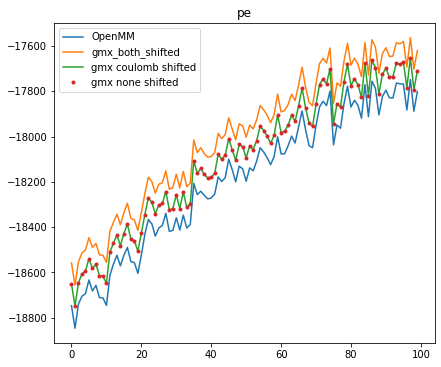

Best results with following gromacs settings:
```
nsteps                    = 1000                      ; global
integrator                = sd                        ; global
dt                        = 0.002                     ; global
pbc                       = xyz                       ; global
;
; -- Bond parameters -- DONT EDIT
constraint_algorithm      = lincs                     ; holonomic constraints
constraints               = all-bonds                 ; all bonds (even heavy atom-H bonds) constrained
lincs_iter                = 1                         ; accuracy of LINCS
lincs_order               = 4                         ; also related to accuracy
;
;
; -- Neighbour searching -- DONT EDIT
cutoff-scheme             = verlet                    ; Verlet Neighbour searching
vdw-modifier              = None                      ; shifting/switching function applied
ns_type                   = grid                      ; search neighbouring grid cells
nstlist                   = 10                        ; steps = 20 fs, not important for verlet
rvdw                      = 1.4                       ; short-range van der Waals cutoff (in nm)
DispCorr                  = EnerPres                  ; account for cut-off vdW scheme
; -- Electrostatics --  DONT EDIT
rcoulomb                  = 1.4                       ; short-range electrostatic cutoff (in nm)
coulomb-modifier          = None                      ; shifting/switching function applied
coulombtype               = PME                       ; Particle Mesh Ewald for long-range electrostatics
pme_order                 = 4                         ; cubic interpolation
fourierspacing            = 0.16                      ; grid spacing for FFT
; -- Thermostat -- Langevin
tc-grps         = Protein              ; two coupling groups - more accurate
tau_t           = 2                    ; inverse friction (in ps)
ref_t           = 300                  ; reference temperature, one for each group (in K)

and these OpenMM settings:

system = top_aa.createSystem(nonbondedMethod=app.forcefield.PME, 
                             nonbondedCutoff=1.4 * u.nanometer,
                             constraints=app.forcefield.AllBonds,
                             rigidWater=False,
                             implicitSolvent=None,
                             soluteDielectric=1.0,
                             solventDielectric=1.0,
                             ewaldErrorTolerance=0.00005,
                             removeCMMotion=False)
                             
integrator = mm.LangevinIntegrator(300*u.kelvin, 0.5/u.picosecond,0.002*u.picoseconds)
```

## Usage:
```python
from simtk.openmm import app
import simtk.openmm as mm
import simtk.unit as u
from custom_gromacstopfile import CustomGromacsTopFile

# input
top_file  = ''             # atomistic topology
gro_file_aa = ''           # atomistic structure

gro_raw = app.gromacsgrofile.GromacsGroFile(gro_file_aa)
top_aa = CustomGromacsTopFile(top_file,
            periodicBoxVectors=gro_raw.getPeriodicBoxVectors(),
            includeDir='/home/soft/gromacs/gromacs-2020/inst/cuda_shared_18.04/share/gromacs/top/')
system = top_aa.createSystem(nonbondedMethod=app.forcefield.PME, 
                             nonbondedCutoff=1.4 * u.nanometer,
                             constraints=app.forcefield.AllBonds,
                             rigidWater=False,
                             implicitSolvent=None,
                             soluteDielectric=1.0,
                             solventDielectric=1.0,
                             ewaldErrorTolerance=0.00005,
                             removeCMMotion=False)

integrator = mm.LangevinIntegrator(300*u.kelvin, 0.5/u.picosecond,0.002*u.picoseconds)
plat = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(top_aa.topology, system, integrator)
simulation.context.setPositions(gro_raw.positions)
simulation.context.setVelocitiesToTemperature(300*u.kelvin)
#Reporters here
simulation.minimizeEnergy()
simulation.step(1000)
```